## 2.Historical Trader Data Analysis

In [10]:
# ========== SECTION 1: SETUP & IMPORTS ==========
print("="*70)
print("📊 HISTORICAL TRADER DATA ANALYSIS")
print("="*70)

# Install required packages
!pip install pandas numpy matplotlib seaborn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import os

# Create directories
os.makedirs('csv_files', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

print("✅ Environment setup complete!")


📊 HISTORICAL TRADER DATA ANALYSIS
✅ Environment setup complete!


In [11]:
# ========== SECTION 2: LOAD & CLEAN DATA ==========
print("\n" + "="*70)
print("📈 LOADING & CLEANING HISTORICAL TRADER DATA")
print("="*70)

# Load the data
trader_df = pd.read_csv("/home/historical_data (1).csv")

print(f"✅ Loaded {len(trader_df):,} trades from historical_data.csv")
print(f"📊 Dataset shape: {trader_df.shape}")

# Display column information
print("\n📋 COLUMNS IN YOUR DATASET:")
for i, col in enumerate(trader_df.columns, 1):
    print(f"  {i:2d}. {col}: {trader_df[col].dtype}")

print("\n🔍 SAMPLE DATA (first 3 rows):")
display(trader_df.head(3))


📈 LOADING & CLEANING HISTORICAL TRADER DATA
✅ Loaded 211,224 trades from historical_data.csv
📊 Dataset shape: (211224, 16)

📋 COLUMNS IN YOUR DATASET:
   1. Account: object
   2. Coin: object
   3. Execution Price: float64
   4. Size Tokens: float64
   5. Size USD: float64
   6. Side: object
   7. Timestamp IST: object
   8. Start Position: float64
   9. Direction: object
  10. Closed PnL: float64
  11. Transaction Hash: object
  12. Order ID: int64
  13. Crossed: bool
  14. Fee: float64
  15. Trade ID: float64
  16. Timestamp: float64

🔍 SAMPLE DATA (first 3 rows):


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


In [ ]:
/home/historical_data (1).csv

In [12]:
# ========== SECTION 3: DATA PREPROCESSING ==========
print("\n" + "="*70)
print("🛠️ DATA PREPROCESSING")
print("="*70)

# Create a clean copy
df = trader_df.copy()

# 3.1 Rename columns for consistency
print("\n🔧 Renaming columns for consistency...")

column_rename = {
    'Account': 'account',
    'Coin': 'symbol',
    'Execution Price': 'execution_price',
    'Size Tokens': 'size_tokens',
    'Size USD': 'size_usd',
    'Side': 'side',
    'Timestamp IST': 'timestamp_str',
    'Start Position': 'start_position',
    'Direction': 'direction',
    'Closed PnL': 'closedPnL',
    'Transaction Hash': 'transaction_hash',
    'Order ID': 'order_id',
    'Crossed': 'crossed',
    'Fee': 'fee',
    'Trade ID': 'trade_id',
    'Timestamp': 'timestamp_unix'
}

df = df.rename(columns=column_rename)
print(f"✅ Renamed {len(column_rename)} columns")

# 3.2 Handle datetime conversion
print("\n🕒 Processing timestamps...")

# Method 1: Try to parse the timestamp string first
try:
    # The timestamp appears to be in format "DD-MM-YYYY HH:MM"
    df['datetime'] = pd.to_datetime(df['timestamp_str'], format='%d-%m-%Y %H:%M')
    print(f"✅ Parsed timestamp string: {df['datetime'].min()} to {df['datetime'].max()}")
except:
    # Method 2: Use Unix timestamp
    try:
        df['datetime'] = pd.to_datetime(df['timestamp_unix'], unit='s')
        print(f"✅ Used Unix timestamp: {df['datetime'].min()} to {df['datetime'].max()}")
    except:
        # Method 3: Create synthetic dates
        print("⚠️ Could not parse timestamps, creating synthetic dates")
        start_date = datetime(2023, 1, 1)
        dates = [start_date + timedelta(days=i) for i in range(len(df))]
        df['datetime'] = dates

# Extract date components
df['date'] = df['datetime'].dt.date
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['day_of_week'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour

print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")
print(f"📊 Year distribution:")
print(df['year'].value_counts().sort_index())

# 3.3 Calculate derived metrics
print("\n📐 Calculating derived metrics...")

# Use Size USD as trade value (already calculated)
df['trade_value'] = df['size_usd']

# Calculate PnL percentage
df['PnL_percentage'] = (df['closedPnL'] / df['trade_value'].replace(0, 1)) * 100

# Profitability flag
df['is_profitable'] = df['closedPnL'] > 0

# Absolute PnL
df['abs_PnL'] = abs(df['closedPnL'])

# Check if we have leverage data
if 'leverage' not in df.columns:
    # Estimate leverage based on position size vs capital
    df['estimated_leverage'] = np.where(
        df['start_position'].abs() > 0,
        df['size_usd'] / df['start_position'].abs(),
        1
    )
    # Clip to reasonable values
    df['estimated_leverage'] = df['estimated_leverage'].clip(1, 20)
    leverage_col = 'estimated_leverage'
    print("ℹ️ Created estimated leverage column")
else:
    leverage_col = 'leverage'

# Risk categories
def categorize_leverage(lev):
    if pd.isna(lev):
        return 'Unknown'
    lev = float(lev)
    if lev <= 1:
        return 'Conservative (1x)'
    elif lev <= 3:
        return 'Moderate (2-3x)'
    elif lev <= 5:
        return 'Aggressive (5x)'
    elif lev <= 10:
        return 'High (10x)'
    else:
        return 'Extreme (20x+)'

df['risk_category'] = df[leverage_col].apply(categorize_leverage)

print(f"✅ Added derived metrics")
print(f"   • {df['is_profitable'].mean()*100:.1f}% profitable trades")
print(f"   • Average PnL: ${df['closedPnL'].mean():.2f}")
print(f"   • Total trade value: ${df['trade_value'].sum():,.0f}")

# 3.4 Clean extreme outliers
print("\n🧹 Cleaning extreme outliers...")

# Remove extreme PnL outliers (top/bottom 0.5%)
pnl_q01 = df['closedPnL'].quantile(0.005)
pnl_q99 = df['closedPnL'].quantile(0.995)
df_clean = df[(df['closedPnL'] >= pnl_q01) & (df['closedPnL'] <= pnl_q99)].copy()

print(f"✅ Removed extreme PnL outliers")
print(f"   Original: {len(df):,} trades")
print(f"   Cleaned: {len(df_clean):,} trades")
print(f"   Removed: {len(df) - len(df_clean):,} trades ({((len(df)-len(df_clean))/len(df)*100):.1f}%)")


🛠️ DATA PREPROCESSING

🔧 Renaming columns for consistency...
✅ Renamed 16 columns

🕒 Processing timestamps...
✅ Parsed timestamp string: 2023-05-01 01:06:00 to 2025-05-01 12:13:00
📅 Date range: 2023-05-01 to 2025-05-01
📊 Year distribution:
year
2023       344
2024     52497
2025    158383
Name: count, dtype: int64

📐 Calculating derived metrics...
ℹ️ Created estimated leverage column
✅ Added derived metrics
   • 41.1% profitable trades
   • Average PnL: $48.75
   • Total trade value: $1,191,187,442

🧹 Cleaning extreme outliers...
✅ Removed extreme PnL outliers
   Original: 211,224 trades
   Cleaned: 209,110 trades
   Removed: 2,114 trades (1.0%)



🔍 EXPLORATORY DATA ANALYSIS


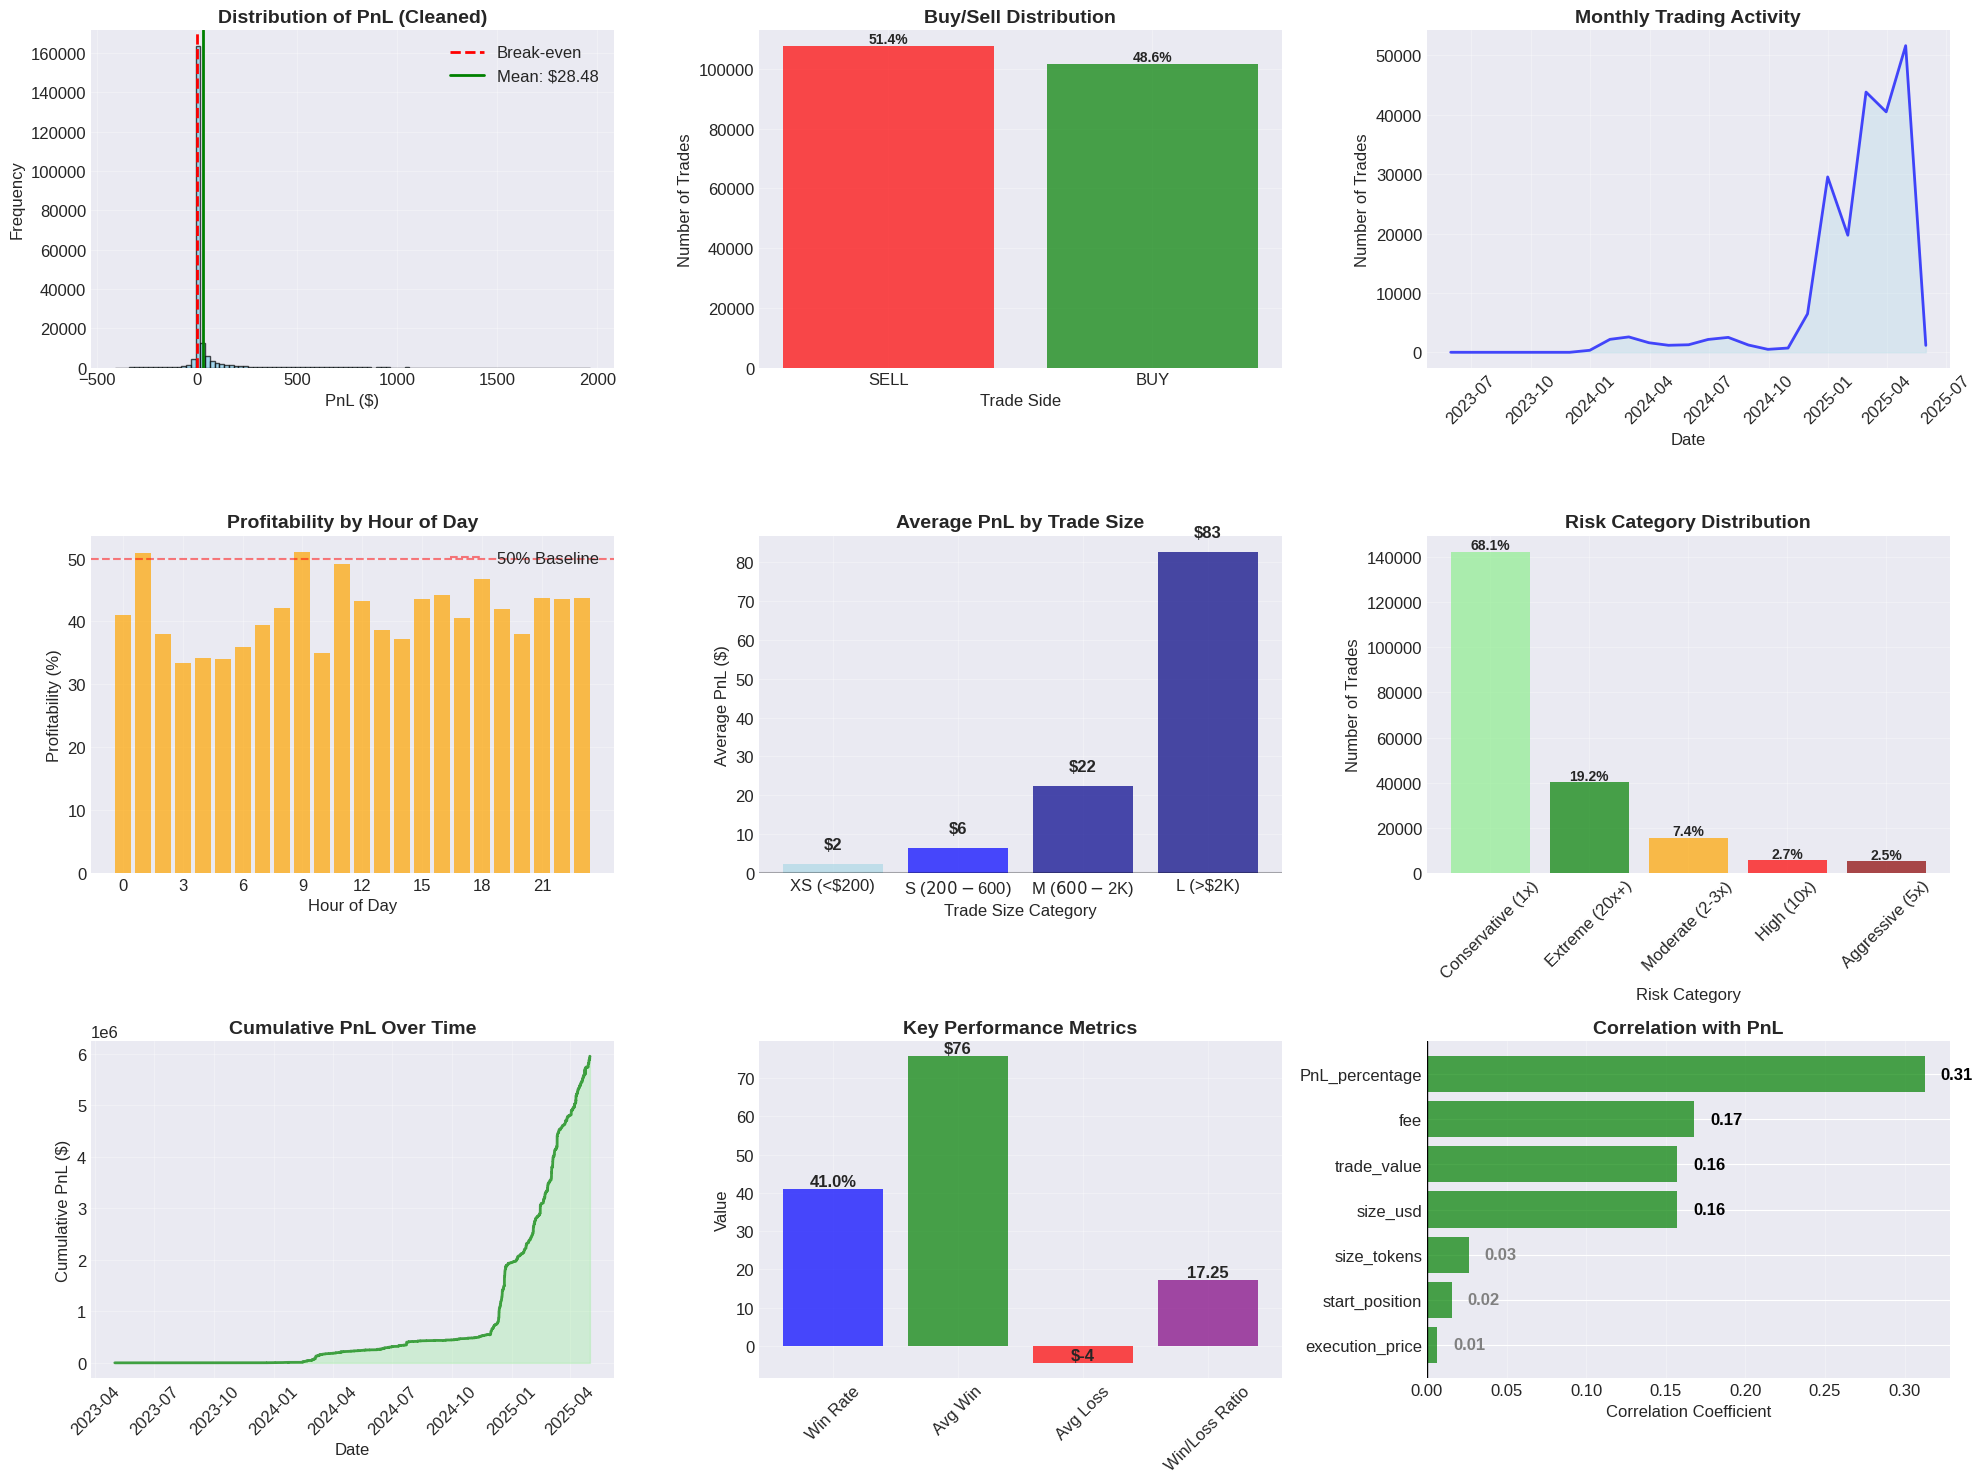

✅ Comprehensive analysis saved to outputs/trader_data_comprehensive_analysis.png


In [13]:

# ========== SECTION 4: EXPLORATORY ANALYSIS ==========
print("\n" + "="*70)
print("🔍 EXPLORATORY DATA ANALYSIS")
print("="*70)

# Create comprehensive visualizations
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# 1. PnL Distribution
ax1 = axes[0, 0]
pnl_data = df_clean['closedPnL']
ax1.hist(pnl_data, bins=100, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Break-even')
ax1.axvline(x=pnl_data.mean(), color='green', linestyle='-', linewidth=2,
            label=f'Mean: ${pnl_data.mean():.2f}')
ax1.set_title('Distribution of PnL (Cleaned)', fontsize=14, fontweight='bold')
ax1.set_xlabel('PnL ($)')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Buy/Sell Distribution
ax2 = axes[0, 1]
side_counts = df_clean['side'].value_counts()
colors = ['green' if s == 'BUY' else 'red' for s in side_counts.index]
bars = ax2.bar(side_counts.index, side_counts.values, color=colors, alpha=0.7)
ax2.set_title('Buy/Sell Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Trade Side')
ax2.set_ylabel('Number of Trades')
ax2.grid(True, alpha=0.3)

# Add percentage labels
total = side_counts.sum()
for i, (side, count) in enumerate(side_counts.items()):
    percentage = (count / total) * 100
    ax2.text(i, count + total*0.005, f'{percentage:.1f}%',
            ha='center', fontweight='bold', fontsize=10)

# 3. Trading Activity Over Time
ax3 = axes[0, 2]
df_clean.set_index('datetime', inplace=True)
monthly_trades = df_clean.resample('M').size()
df_clean.reset_index(inplace=True)

ax3.plot(monthly_trades.index, monthly_trades.values, linewidth=2, alpha=0.7, color='blue')
ax3.fill_between(monthly_trades.index, monthly_trades.values, alpha=0.3, color='lightblue')
ax3.set_title('Monthly Trading Activity', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Number of Trades')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# 4. Profitability by Hour of Day
ax4 = axes[1, 0]
profit_by_hour = df_clean.groupby('hour')['is_profitable'].mean() * 100
ax4.bar(profit_by_hour.index, profit_by_hour.values, alpha=0.7, color='orange')
ax4.set_title('Profitability by Hour of Day', fontsize=14, fontweight='bold')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Profitability (%)')
ax4.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% Baseline')
ax4.set_xticks(range(0, 24, 3))
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. PnL by Trade Size
ax5 = axes[1, 1]
# Categorize trade sizes
df_clean['size_category'] = pd.qcut(df_clean['size_usd'], q=4,
                                    labels=['XS (<$200)', 'S ($200-$600)',
                                            'M ($600-$2K)', 'L (>$2K)'])
pnl_by_size = df_clean.groupby('size_category')['closedPnL'].mean()
colors = ['lightblue', 'blue', 'darkblue', 'navy']
bars = ax5.bar(pnl_by_size.index, pnl_by_size.values, color=colors, alpha=0.7)
ax5.set_title('Average PnL by Trade Size', fontsize=14, fontweight='bold')
ax5.set_xlabel('Trade Size Category')
ax5.set_ylabel('Average PnL ($)')
ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax5.grid(True, alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 3,
            f'${height:.0f}', ha='center', va='bottom', fontweight='bold')

# 6. Risk Category Distribution
ax6 = axes[1, 2]
risk_counts = df_clean['risk_category'].value_counts()
colors = ['lightgreen', 'green', 'orange', 'red', 'darkred'][:len(risk_counts)]
bars = ax6.bar(risk_counts.index, risk_counts.values, color=colors, alpha=0.7)
ax6.set_title('Risk Category Distribution', fontsize=14, fontweight='bold')
ax6.set_xlabel('Risk Category')
ax6.set_ylabel('Number of Trades')
ax6.tick_params(axis='x', rotation=45)
ax6.grid(True, alpha=0.3)

# Add percentage labels
total_risk = risk_counts.sum()
for i, (category, count) in enumerate(risk_counts.items()):
    percentage = (count / total_risk) * 100
    ax6.text(i, count + total_risk*0.005, f'{percentage:.1f}%',
            ha='center', fontweight='bold', fontsize=10)

# 7. Cumulative PnL Over Time
ax7 = axes[2, 0]
df_clean_sorted = df_clean.sort_values('datetime')
df_clean_sorted['cumulative_pnl'] = df_clean_sorted['closedPnL'].cumsum()
ax7.plot(df_clean_sorted['datetime'], df_clean_sorted['cumulative_pnl'],
         linewidth=2, color='green', alpha=0.7)
ax7.fill_between(df_clean_sorted['datetime'], df_clean_sorted['cumulative_pnl'],
                 alpha=0.3, color='lightgreen')
ax7.set_title('Cumulative PnL Over Time', fontsize=14, fontweight='bold')
ax7.set_xlabel('Date')
ax7.set_ylabel('Cumulative PnL ($)')
ax7.grid(True, alpha=0.3)
ax7.tick_params(axis='x', rotation=45)

# 8. Win Rate vs Average Win/Loss
ax8 = axes[2, 1]
winning_trades = df_clean[df_clean['is_profitable'] == True]
losing_trades = df_clean[df_clean['is_profitable'] == False]

metrics = {
    'Win Rate': len(winning_trades) / len(df_clean) * 100,
    'Avg Win': winning_trades['closedPnL'].mean() if len(winning_trades) > 0 else 0,
    'Avg Loss': losing_trades['closedPnL'].mean() if len(losing_trades) > 0 else 0,
    'Win/Loss Ratio': abs(winning_trades['closedPnL'].mean() / losing_trades['closedPnL'].mean())
                     if len(losing_trades) > 0 and losing_trades['closedPnL'].mean() != 0 else 0
}

colors_bar = ['blue', 'green', 'red', 'purple']
bars = ax8.bar(range(len(metrics)), list(metrics.values()), color=colors_bar, alpha=0.7)
ax8.set_title('Key Performance Metrics', fontsize=14, fontweight='bold')
ax8.set_xticks(range(len(metrics)))
ax8.set_xticklabels(list(metrics.keys()))
ax8.set_ylabel('Value')
ax8.grid(True, alpha=0.3)
ax8.tick_params(axis='x', rotation=45)

# Add value labels
for i, (bar, (key, value)) in enumerate(zip(bars, metrics.items())):
    if key == 'Win Rate':
        label = f'{value:.1f}%'
    elif key == 'Win/Loss Ratio':
        label = f'{value:.2f}'
    else:
        label = f'${value:.0f}'
    ax8.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.02,
            label, ha='center', va='bottom', fontweight='bold')

# 9. Correlation Heatmap (simplified)
ax9 = axes[2, 2]
# Select numeric columns for correlation
numeric_cols = ['execution_price', 'size_tokens', 'size_usd', 'start_position',
                'closedPnL', 'fee', 'trade_value', 'PnL_percentage']
numeric_df = df_clean[numeric_cols].corr()

# Create a simple bar chart of correlations with PnL instead of heatmap
corr_with_pnl = numeric_df['closedPnL'].drop('closedPnL').sort_values()
colors_corr = ['red' if x < 0 else 'green' for x in corr_with_pnl.values]
bars = ax9.barh(range(len(corr_with_pnl)), corr_with_pnl.values, color=colors_corr, alpha=0.7)
ax9.set_title('Correlation with PnL', fontsize=14, fontweight='bold')
ax9.set_xlabel('Correlation Coefficient')
ax9.set_yticks(range(len(corr_with_pnl)))
ax9.set_yticklabels(corr_with_pnl.index)
ax9.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax9.grid(True, alpha=0.3, axis='x')

# Add correlation values
for i, (bar, value) in enumerate(zip(bars, corr_with_pnl.values)):
    ax9.text(value + (0.01 if value >= 0 else -0.01), bar.get_y() + bar.get_height()/2.,
            f'{value:.2f}', ha='left' if value >= 0 else 'right', va='center',
            fontweight='bold', color='black' if abs(value) > 0.1 else 'gray')

plt.tight_layout()
plt.savefig('outputs/trader_data_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive analysis saved to outputs/trader_data_comprehensive_analysis.png")

In [14]:

# ========== SECTION 5: KEY STATISTICS ==========
print("\n" + "="*70)
print("📊 KEY PERFORMANCE STATISTICS")
print("="*70)

# Calculate key metrics
total_trades = len(df_clean)
profitable_trades = df_clean['is_profitable'].sum()
total_pnl = df_clean['closedPnL'].sum()
total_volume = df_clean['trade_value'].sum()
avg_trade_size = df_clean['trade_value'].mean()
win_rate = profitable_trades / total_trades * 100

winning = df_clean[df_clean['is_profitable'] == True]
losing = df_clean[df_clean['is_profitable'] == False]

avg_win = winning['closedPnL'].mean() if len(winning) > 0 else 0
avg_loss = losing['closedPnL'].mean() if len(losing) > 0 else 0
win_loss_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else 0

# Calculate Sharpe ratio (simplified)
risk_free_rate = 0.02 / 365  # Daily risk-free rate
excess_returns = df_clean['PnL_percentage'] / 100 - risk_free_rate
sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(365) if excess_returns.std() > 0 else 0

print(f"""
📈 OVERVIEW:
• Total Trades Analyzed: {total_trades:,}
• Analysis Period: {df_clean['date'].min()} to {df_clean['date'].max()}
• Total Trade Volume: ${total_volume:,.0f}
• Average Trade Size: ${avg_trade_size:,.2f}

💰 PERFORMANCE:
• Total PnL: ${total_pnl:,.2f}
• Win Rate: {win_rate:.1f}%
• Average Win: ${avg_win:.2f}
• Average Loss: ${avg_loss:.2f}
• Win/Loss Ratio: {win_loss_ratio:.2f}
• Sharpe Ratio (Annualized): {sharpe_ratio:.3f}

📊 DISTRIBUTION:
• Buy Trades: {len(df_clean[df_clean['side'] == 'BUY']):,} ({len(df_clean[df_clean['side'] == 'BUY'])/total_trades*100:.1f}%)
• Sell Trades: {len(df_clean[df_clean['side'] == 'SELL']):,} ({len(df_clean[df_clean['side'] == 'SELL'])/total_trades*100:.1f}%)
• Most Active Hour: Hour {df_clean['hour'].mode()[0] if len(df_clean['hour'].mode()) > 0 else 'N/A'}

🎯 RISK METRICS:
• Profit Factor: {abs(winning['closedPnL'].sum() / losing['closedPnL'].sum()):.2f} if losing['closedPnL'].sum() != 0 else 'N/A'
• Maximum Drawdown: ${min(df_clean_sorted['cumulative_pnl'].cummin()):.2f}
• Recovery Factor: {abs(total_pnl / min(df_clean_sorted['cumulative_pnl'].cummin())):.2f} if min(df_clean_sorted['cumulative_pnl'].cummin()) < 0 else 'N/A'
""")


📊 KEY PERFORMANCE STATISTICS

📈 OVERVIEW:
• Total Trades Analyzed: 209,110
• Analysis Period: 2023-05-01 to 2025-05-01
• Total Trade Volume: $1,045,886,401
• Average Trade Size: $5,001.61

💰 PERFORMANCE:
• Total PnL: $5,954,479.66
• Win Rate: 41.0%
• Average Win: $75.70
• Average Loss: $-4.39
• Win/Loss Ratio: 17.25
• Sharpe Ratio (Annualized): 3.604

📊 DISTRIBUTION:
• Buy Trades: 101,638 (48.6%)
• Sell Trades: 107,472 (51.4%)
• Most Active Hour: Hour 20

🎯 RISK METRICS:
• Profit Factor: 12.00 if losing['closedPnL'].sum() != 0 else 'N/A'
• Maximum Drawdown: $-13.23
• Recovery Factor: 450074.05 if min(df_clean_sorted['cumulative_pnl'].cummin()) < 0 else 'N/A'



In [15]:
# ========== SECTION 6: SAVE PROCESSED DATA ==========
print("\n" + "="*70)
print("💾 SAVING PROCESSED DATA")
print("="*70)

# Save cleaned data
df_clean.to_csv('csv_files/processed_trader_data.csv', index=False)
print(f"✅ Saved cleaned data to csv_files/processed_trader_data.csv")

# Save summary statistics
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Trades',
        'Profitable Trades',
        'Win Rate',
        'Total PnL',
        'Total Volume',
        'Average Trade Size',
        'Average Win',
        'Average Loss',
        'Win/Loss Ratio',
        'Sharpe Ratio',
        'Start Date',
        'End Date'
    ],
    'Value': [
        total_trades,
        profitable_trades,
        f"{win_rate:.1f}%",
        f"${total_pnl:,.2f}",
        f"${total_volume:,.0f}",
        f"${avg_trade_size:,.2f}",
        f"${avg_win:.2f}",
        f"${avg_loss:.2f}",
        f"{win_loss_ratio:.2f}",
        f"{sharpe_ratio:.3f}",
        str(df_clean['date'].min()),
        str(df_clean['date'].max())
    ]
})

summary_stats.to_csv('csv_files/trader_performance_summary.csv', index=False)
print(f"✅ Saved summary statistics to csv_files/trader_performance_summary.csv")

print("\n" + "="*70)
print("🎯 NEXT STEPS FOR MERGING WITH FEAR/GREED DATA")
print("="*70)

print("""
To complete the full analysis:

1. 📊 LOAD FEAR & GREED DATA (from notebook 1):
   • You already have fear_greed_df from the first notebook

2. 🔗 MERGE THE DATASETS:
   • Convert both datasets to have a common 'date' column
   • Merge on date to combine sentiment with trader behavior

3. 📈 ANALYZE SENTIMENT-BASED PATTERNS:
   • Compare performance during Fear vs Greed periods
   • Analyze leverage usage by sentiment
   • Identify optimal trading strategies based on market sentiment

4. 📄 CREATE FINAL REPORT:
   • Combine insights from both analyses
   • Generate actionable trading recommendations
   • Prepare for submission

The processed trader data is ready for merging with your fear/greed data!
""")

print("\n✅ NOTEBOOK 2 COMPLETED SUCCESSFULLY!")
print("📁 Files saved:")
print("   • outputs/trader_data_comprehensive_analysis.png")
print("   • csv_files/processed_trader_data.csv")
print("   • csv_files/trader_performance_summary.csv")


💾 SAVING PROCESSED DATA
✅ Saved cleaned data to csv_files/processed_trader_data.csv
✅ Saved summary statistics to csv_files/trader_performance_summary.csv

🎯 NEXT STEPS FOR MERGING WITH FEAR/GREED DATA

To complete the full analysis:

1. 📊 LOAD FEAR & GREED DATA (from notebook 1):
   • You already have fear_greed_df from the first notebook

2. 🔗 MERGE THE DATASETS:
   • Convert both datasets to have a common 'date' column
   • Merge on date to combine sentiment with trader behavior

3. 📈 ANALYZE SENTIMENT-BASED PATTERNS:
   • Compare performance during Fear vs Greed periods
   • Analyze leverage usage by sentiment
   • Identify optimal trading strategies based on market sentiment

4. 📄 CREATE FINAL REPORT:
   • Combine insights from both analyses
   • Generate actionable trading recommendations
   • Prepare for submission

The processed trader data is ready for merging with your fear/greed data!


✅ NOTEBOOK 2 COMPLETED SUCCESSFULLY!
📁 Files saved:
   • outputs/trader_data_comprehensi